In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    auc
)
from sklearn.model_selection import cross_val_score

In [2]:
# Load the model and data
with open('../models/model.pkl', 'rb') as f:
    model_data = pickle.load(f)

In [3]:
# Load and prepare test data
df = pd.read_csv('../data/diabetes_dataset_processed.csv')

In [4]:
def prepare_features(df):
    """Prepare features using saved preprocessors"""
    numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'cardiovascular_risk']
    categorical_cols = ['gender', 'smoking_history', 'bmi_category', 'HbA1c_category', 'glucose_category']
    
    # Scale numerical features
    X_num = df[numerical_cols].copy()
    X_num_scaled = model_data['scaler'].transform(X_num)
    X_num_scaled = pd.DataFrame(X_num_scaled, columns=numerical_cols)
    
    # Encode categorical features
    X_cat = df[categorical_cols].copy()
    X_cat_encoded = pd.DataFrame()
    for col in categorical_cols:
        X_cat_encoded[col] = model_data['encoders'][col].transform(X_cat[col])
    
    # Combine features
    X = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
    y = df['diabetes']
    
    return X, y

In [5]:
X, y = prepare_features(df)

In [6]:
# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Get predictions
y_pred = model_data['model'].predict(X_test)
y_pred_proba = model_data['model'].predict_proba(X_test)[:, 1]

In [8]:
# 1. Accuracy
print("1. Accuracy")
print("-----------")
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy = {accuracy:.3f}')
print()

1. Accuracy
-----------
Accuracy = 0.960



Very high overall accuracy
However, with imbalanced medical data, we need to look deeper at other metrics

In [9]:
# 2. Confusion Table
print("2. Confusion Table")
print("-----------------")
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'True Negative (TN): {tn}')
print(f'False Positive (FP): {fp}')
print(f'False Negative (FN): {fn}')
print(f'True Positive (TP): {tp}')

print(f'\nTotal observations: {len(y_test)}')
print()

2. Confusion Table
-----------------
True Negative (TN): 18194
False Positive (FP): 98
False Negative (FN): 695
True Positive (TP): 1013

Total observations: 20000



## Confusion Table Analysis

- Data is imbalanced (18,889 negative vs 1,111 positive cases)
- False Negatives (695) are concerning as these are missed diabetes cases
- Very few False Positives (98) which is good

In [15]:
# 3. Precision
print("3. Precision")
print("-----------")
precision = precision_score(y_test, y_pred)
print(f'Precision = {precision:.3f}')
print()

3. Precision
-----------
Precision = 0.912



- Of those predicted as having diabetes, 91.2% actually have it
- Very good precision, meaning low false alarm rate
- Important for avoiding unnecessary worry/testing

In [11]:
# 4. Recall
print("4. Recall")
print("---------")
recall = recall_score(y_test, y_pred)
print(f'Recall = {recall:.3f}')
print()

4. Recall
---------
Recall = 0.593



- Model only catches 59.3% of actual diabetes cases
- This is the main area for improvement
- Missing ~40% of diabetes cases is significant in medical context

5. ROC Curve
-----------


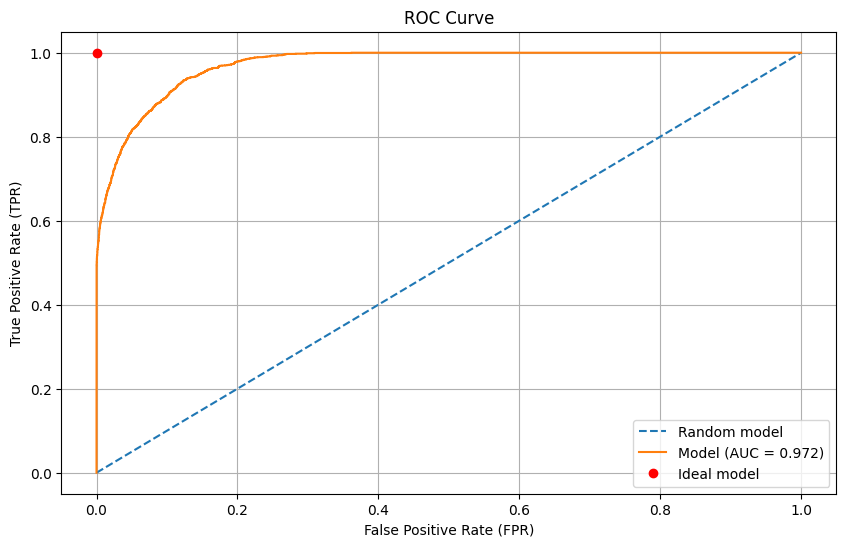

AUC = 0.972



In [12]:
# 5. ROC Curve
print("5. ROC Curve")
print("-----------")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(10, 6))

# Plot random model
plt.plot([0, 1], [0, 1], '--', label='Random model')

# Plot our model's ROC curve
plt.plot(fpr, tpr, label=f'Model (AUC = {auc_score:.3f})')

# Mark the ideal point (0,1)
plt.plot([0], [1], 'ro', label='Ideal model')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f'AUC = {auc_score:.3f}')
print()

- Excellent AUC score
- Shows great discriminative ability
- Consistent across cross-validation (low std dev: ±0.003)

In [13]:
# 6. Cross-Validation
print("6. Cross-Validation")
print("-----------------")
cv_scores = cross_val_score(
    model_data['model'], 
    X, 
    y, 
    cv=5,
    scoring='roc_auc'
)

print('Cross-Validation Scores:')
for i, score in enumerate(cv_scores, 1):
    print(f'Fold {i}: {score:.3f}')
print(f'\nMean ROC AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})')

6. Cross-Validation
-----------------


/home/calvin/mlzoomcamp/.venv/lib64/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/calvin/mlzoomcamp/.venv/lib64/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/calvin/mlzoomcamp/.venv/lib64/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:45:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/calvin/mlzoomcamp/.venv/lib64/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:45:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/calvin/mlzoomcamp/.venv/lib64/python3.12/site-packages/xgboost

Cross-Validation Scores:
Fold 1: 0.970
Fold 2: 0.972
Fold 3: 0.968
Fold 4: 0.972
Fold 5: 0.971

Mean ROC AUC: 0.971 (+/- 0.003)


In [14]:
# Save results to file
results = {
    'accuracy': accuracy,
    'confusion_matrix': {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    },
    'precision': precision,
    'recall': recall,
    'auc': auc_score,
    'cv_scores': {
        'mean': float(cv_scores.mean()),
        'std': float(cv_scores.std())
    }
}

# Save evaluation results
with open('../models/evaluation_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\nEvaluation results have been saved to '../models/evaluation_results.pkl'")


Evaluation results have been saved to '../models/evaluation_results.pkl'


Seems some fine-tuning is needed. Lets go to evaluate-2.ipynb